In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.stats import norm
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

pd.set_option('max_columns', 100)

# Visualization Libraries
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import time


# torch things
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader


# Extras
import math, string, os
from string import punctuation
import re
import math
from scipy.spatial import Voronoi, voronoi_plot_2d
import copy

from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA

# new 
from sklearn.model_selection import train_test_split

In [0]:
# parameters
BATCH_SIZE = 1024
TEST_BATCH_SIZE = 10*BATCH_SIZE
EPOCHS = 150
DROPOUT_RATE = 0.25
DEPTH = 5
WIDTH = 128
LEARNING_RATE = 1e-4
NOISY=0.00005
# NOISY=1.5
BIG_YARDCUTOFF = 30
SMALL_YARDCUTOFF = -100

# cuda stuff
USE_CUDA = False
use_cuda = USE_CUDA and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

## NN only

In [0]:
eps = 1e-10

class FullyConnected(nn.Module):
    def __init__(self, in_dim, out_dim, depth=1, width=500, dropout_rate=0.1):
        """
        Mama mia
        """
        super(FullyConnected, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.depth = depth
        self.width = width
        self.dropout_rate = dropout_rate

        # build model layers
        mid_layer = [nn.Linear(width, width), nn.ReLU(), nn.Dropout(dropout_rate)]

        all_layers = [nn.Linear(in_dim, width), nn.ReLU()]
        for d in range(depth):
            all_layers.extend(mid_layer)
        all_layers.append(nn.Linear(width, out_dim))
        all_layers.append(nn.Softmax(dim=1))


        self.model = nn.Sequential(*all_layers)

    def forward(self, x):
        out = self.model(x)
        out = torch.clamp(out.cumsum(1), min=eps, max=1 - eps)
        return out

    def loss(self, guess, label, device):
        # L = F.binary_cross_entropy(guess, label.to(device))
        # L = torch.mean(torch.sum(torch.pow(guess-label,2))/(199))
        L = F.mse_loss(guess, label) + F.mse_loss(guess.sum(), label.sum())*1/(100000000)
        # L = F.mse_loss(guess.sum(), label.sum())/F.mse_loss(guess, label)

        return L

class ResFullyConnected(nn.Module):
    def __init__(self, in_dim, out_dim, depth=1, width=500, dropout_rate=0.1):
        """
        Mama mia
        """
        super(ResFullyConnected, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.depth = depth
        self.width = width
        self.dropout_rate = dropout_rate

        # build model layers
        mid_layer = [nn.Linear(width, width), nn.ReLU(), nn.Dropout(dropout_rate)]

        all_layers = [nn.Linear(in_dim, width), nn.ReLU()]
        for d in range(depth):
            all_layers.extend(mid_layer)
        all_layers.append(nn.Linear(width, out_dim))
        all_layers.append(nn.Softmax(dim=1))
        # self.model = nn.Sequential(*all_layers)
        # self.model = all_layers
        self.layers = all_layers

    def forward(self, x):
        out = self.layers[0](x)
        out = self.layers[1](x)
        for i, layer in enumerate(self.layers[2:-2]):
            # skip connections inside
            if i % 3 == 2:
                # because each mid layer has 3 sublayers
                out = layer(out)
                out = self.layers[i+1](out)
                out = self.layers[i+2](out) + out
        out = self.layers[-2](out)
        out = self.layers[-1](out)
        
        out = torch.clamp(out.cumsum(1), min=eps, max=1 - eps)
        return out

    def loss(self, guess, label, device):
        L = F.binary_cross_entropy(guess, label.to(device))
        return L

def train(model, device, train_loader, optimizer, epoch, log_interval=1e5, verbose=True):
    model.train()
    train_loss = 0

    for batch_idx, (data, yardage) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)

        loss = model.loss(output, yardage, device)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        if batch_idx % log_interval == 0:
            if verbose:
                print('{} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    time.ctime(time.time()), epoch, batch_idx * len(data),
                    len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))

    train_loss /= len(train_loader)
    if verbose:
        print('Train set Average loss:', train_loss)
    return train_loss

def label_to_cdf(label, noisy=None):
    """
    labels are the yards gained. thus the cdf is a step function at yards gained

    noisy: treat yards as a gaussian centered on label with sigma = noisy
    """
    label = label + 99 # to adjust for negative yards
    if noisy:
        # noisy = number of bins to noise over
        bins = [199 - i for i in range(199)]
        cdf = norm.cdf(bins, 199 - label, noisy)
    else:
        cdf = np.sum(np.eye(199)[:label], axis=0) 
    return 1 - cdf

def test(model, device, test_loader, log_interval=1e5, verbose=True, return_predictions=False):
    model.eval()
    test_loss = 0

    all_predictions = []

    with torch.no_grad():
        for batch_idx, (data, yardage) in enumerate(test_loader):
            data = data.to(device)
            output = model(data)
            all_predictions.append(output)
            loss = model.loss(output, yardage, device)
            test_loss += loss.item()

            if log_interval is not None and batch_idx % log_interval == 0:
                if verbose:
                    print('{} Test: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        time.ctime(time.time()),
                        batch_idx * len(data), len(test_loader.dataset),
                        100. * batch_idx / len(test_loader), loss.item()))

    test_loss /= len(test_loader)
    if verbose:
        print('Test set Average loss:', test_loss)

    if return_predictions:
        return all_predictions, test_loss
    return test_loss


class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, data, labels):
        'Initialization'
        self.data = data
        self.labels = labels

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.data)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Load data and get label
        X = self.data[index]
        y = self.labels[index]
        return X, y

## Training stuff

In [0]:
def make_model(IN_DIM, OUT_DIM, width=100, dropout_rate=0.35):
    # model = FullyConnected(IN_DIM, OUT_DIM, dropout_rate=dropout_rate, width=width)
    model = ResFullyConnected(IN_DIM, OUT_DIM, dropout_rate=dropout_rate, width=width)
    return model

xTrainMin = -7777777
def train_model(df, scaler=None, pca=None, width=128): 
    # data already processed
    # xTrain = process(df, test_or_train='train')
    # playId = df['PlayId']
    df = df[df.Yards < BIG_YARDCUTOFF].reset_index(drop=True)
    df = df[df.Yards > SMALL_YARDCUTOFF].reset_index(drop=True)
    yTrain = df['Yards']
    xTrain = df.drop(['Season', 'Quarter', 'WindSpeed'], axis=1)
    # drop all PlayIDs
    xTrain = xTrain.infer_objects()
    xTrain = xTrain.drop([col for col in xTrain.columns if 'PlayId' in col], axis=1)
    xTrain = xTrain.drop([col for col in xTrain.columns if 'NflId' in col], axis=1)
    xTrain = xTrain.select_dtypes(exclude=['object'])

    xTrain = xTrain.drop(['GameId', 'Yards'], axis=1)
    
    # xTrain = xTrain[[col for col in xTrain.columns if ('Voronoi' in col or 'DistanceToRB' in col or 'X_' in col or 'Y' in col or 'S_' in col or 'A_' in col)]]

    # print(xTrain.min()/xTrainMin)
    xTrain = np.log(xTrain - xTrainMin + eps) # to bring things much closer

    x = xTrain

    # clip large outlier values
    clip_min = x.quantile(0.0005, axis=0)
    clip_max = x.quantile(0.9995, axis=0)
    # x = x.clip(clip_min, clip_max, axis=1)

    # std mask
    stdMask = None
    # stdMask = stdMask & (x[x <= x.quantile(0.999)].dropna().std() <= 1000)
    # stdMask = 0 < x[x <= x.quantile(0.999)].dropna().std() 
    # x = x[stdMask]

    # standard scaler
    if scaler == None:
        scaler = StandardScaler()
    scaler.fit(x)
    x = scaler.transform(x)


    # PCA preprocessing
    if pca == None:
        pca = PCA(n_components=max(20, x.shape[-1]//2))
        # pca = FunctionTransformer()
    pca.fit(x)
    x = pca.transform(x)
    print(x.shape)
    x = x.astype('float32')

    # set up labels
    y = np.array([label_to_cdf(l, noisy=NOISY) for l in yTrain])
    y = y.astype('float32')

    # make validation set
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2)
    train_loader = DataLoader(Dataset(x_train, y_train), 
                              batch_size=BATCH_SIZE, shuffle=True)
    valid_loader = DataLoader(Dataset(x_val, y_val), 
                              batch_size=BATCH_SIZE, shuffle=True)
    # make model
    IN_DIM = x.shape[-1]
    OUT_DIM = 199
    model = FullyConnected(IN_DIM, OUT_DIM, dropout_rate=DROPOUT_RATE, 
                           depth=DEPTH, width=WIDTH)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    # model = ResFullyConnected(IN_DIM, OUT_DIM, dropout_rate=DROPOUT_RATE, width=WIDTH)
    # optimizer = torch.optim.Adam([params for layer in model.layers for params in layer.parameters()], lr=LEARNING_RATE)
    
    
    # train nn
    best_loss = 1e10
    best_epoch = 0
    early_stopping = 30
    for epoch in range(0, EPOCHS + 1):
        train_loss = train(model, device, train_loader, optimizer, 
                                      epoch, verbose=True)
        valid_loss = test(model, device, valid_loader, verbose=True)

        if valid_loss < best_loss:
            print("victory")
            best_loss = valid_loss
            best_epoch = epoch
            best_model = copy.deepcopy(model)
        
        if epoch - best_epoch > early_stopping:
            break

    return best_model, stdMask, pca, scaler, clip_min, clip_max
    

def test(model, device, test_loader, log_interval=1e5, verbose=True, return_predictions=False):
    model.eval()
    test_loss = 0

    all_predictions = []

    with torch.no_grad():
        for batch_idx, (data, yardage) in enumerate(test_loader):
            data = data.to(device)
            output = model(data)
            all_predictions.append(output)
            loss = model.loss(output, yardage, device)
            test_loss += loss.item()

            if log_interval is not None and batch_idx % log_interval == 0:
                if verbose:
                    print('{} Test: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        time.ctime(time.time()),
                        batch_idx * len(data), len(test_loader.dataset),
                        100. * batch_idx / len(test_loader), loss.item()))

    test_loss /= len(test_loader)
    if verbose:
        print('Test set Average loss:', test_loss)

    if return_predictions:
        return all_predictions, test_loss
    return test_loss


def predict(model, test_df, stdMask=None, clip_min=-1e10, clip_max=1e10,
            pca=FunctionTransformer, scaler=FunctionTransformer):
    model.eval()
    playId = test_df['PlayId']
    # xTest = process(test_df, test_or_train='test')
    xTest = test_df.drop(['Season', 'Quarter', 'WindSpeed'], axis=1)
    # drop all PlayIDs
    xTest = xTest.infer_objects()
    xTest = xTest.drop([col for col in xTest.columns if 'PlayId' in col], axis=1)
    xTest = xTest.drop([col for col in xTest.columns if 'NflId' in col], axis=1)
    xTest = xTest.select_dtypes(exclude=['object'])
    xTest = xTest.drop(['GameId'], axis=1)

    # xTest = xTest[[col for col in xTest.columns if ('Voronoi' in col or 'DistanceToRB' in col or 'X_' in col or 'Y' in col or 'S_' in col or 'A_' in col)]]
    
    xTest = np.log(xTest - xTrainMin + eps) # to bring things much closer
    x = xTest 

    # clip large outlier values
    # x = x.clip(clip_min, clip_max, axis=1)

    # std scaling
    x = scaler.transform(x)

    # std Mask
    if type(stdMask) != type(None):
        x = x[:, stdMask]

    # PCA preprocessing
    print(x.shape)
    x = pca.transform(x)
    x = x.astype('float32')
    
    data = torch.tensor(x)
#     print(data)
    cdfVals = model(data).detach()
    
    return cdfVals



## Run Training

In [0]:
# View Available Files
from google.colab import drive

drive.mount('/content/gdrive')

# Training data is in the competition dataset as usual
df = pd.read_csv('/content/gdrive/My Drive/nfl/JT/NN Models/processed_data.csv')\


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
msk = np.random.rand(len(df)) < 0.8
train_df = df[msk].reset_index(drop=True)
test_df = df[~msk].reset_index(drop=True)

begin_time = time.time()
ensemble = []
n_models = 1
scaler = None
pca = None
for i in range(n_models):
    rand_width = np.random.randint(25, 1000)
    model, stdMask, pca, scaler, clip_min, clip_max = train_model(train_df, scaler=scaler, pca=pca, width=rand_width)
    ensemble.append(model)

print(time.time() - begin_time)

print("Training done. Start predicting.")

(18295, 226)
Sun Nov 24 18:43:57 2019 Train Epoch: 0 [0/14636 (0%)]	Loss: 0.309565
Train set Average loss: 0.24878647923469543
Sun Nov 24 18:43:57 2019 Test: [0/3659 (0%)]	Loss: 0.242858
Test set Average loss: 0.22144977003335953
victory
Sun Nov 24 18:43:57 2019 Train Epoch: 1 [0/14636 (0%)]	Loss: 0.266224
Train set Average loss: 0.2117425560951233
Sun Nov 24 18:43:58 2019 Test: [0/3659 (0%)]	Loss: 0.204450
Test set Average loss: 0.1861741542816162
victory
Sun Nov 24 18:43:58 2019 Train Epoch: 2 [0/14636 (0%)]	Loss: 0.183555
Train set Average loss: 0.16183341642220814
Sun Nov 24 18:43:58 2019 Test: [0/3659 (0%)]	Loss: 0.137559
Test set Average loss: 0.1298408005386591
victory
Sun Nov 24 18:43:58 2019 Train Epoch: 3 [0/14636 (0%)]	Loss: 0.120806
Train set Average loss: 0.09585190067688625
Sun Nov 24 18:43:59 2019 Test: [0/3659 (0%)]	Loss: 0.082860
Test set Average loss: 0.08284114859998226
victory
Sun Nov 24 18:43:59 2019 Train Epoch: 4 [0/14636 (0%)]	Loss: 0.092663
Train set Average lo

In [0]:
test_y = test_df.Yards
test_y = np.array([label_to_cdf(l, noisy=0) for l in test_y])
test_y = np.array(test_y).astype('float32')

cdfVals = []

for model in ensemble:
    cdfVals.append(predict(model, test_df.drop(columns=['Yards']),
                        stdMask=None, pca=pca, scaler=scaler))
    
cdfVals = torch.mean(torch.stack(cdfVals), axis=0)

(4693, 453)


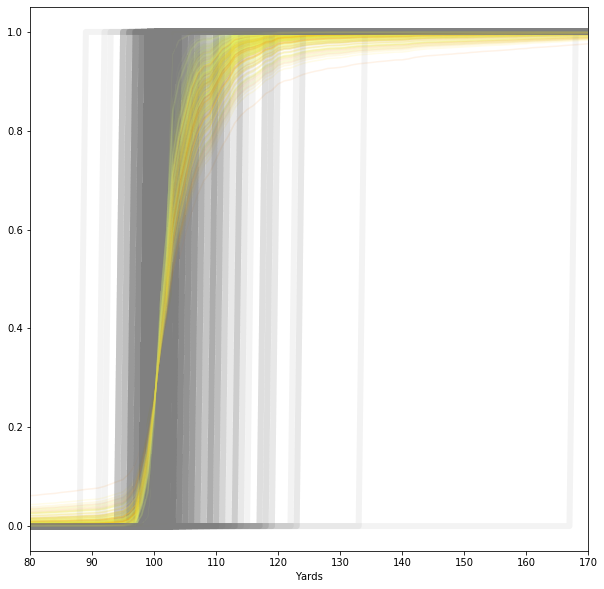

5 NN ensemble:	 0.013802615651237221


In [0]:
plt.figure(figsize=(10,10))
for i in range(test_y.shape[0]//10):
    c = plt.cm.Wistia((110 - test_y[i].sum())/10 - 1.3)
    plt.plot(test_y[i], alpha=3*150/cdfVals.shape[0], color='grey', linewidth=6)
    plt.plot(cdfVals[i], alpha=3*150/cdfVals.shape[0], c=c)
plt.xlim(80, 170)
plt.xlabel("Yards")
plt.show()

combo_score = np.sum(np.power(cdfVals.numpy()-test_y,2))/(199*(len(cdfVals)))

print("5 NN ensemble:\t {}".format(combo_score))

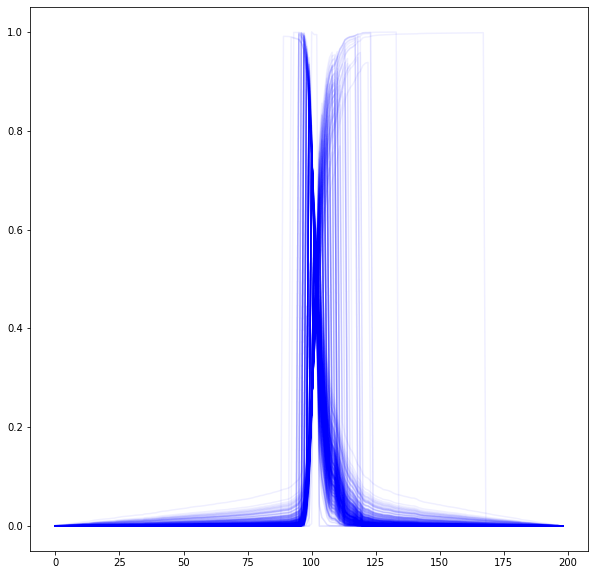

In [0]:
plt.figure(figsize=(10,10))

for i in range(test_y.shape[0]//10):
    c = plt.cm.Wistia((110 - test_y[i].sum())/15 - 0.3)
    plt.plot(abs(cdfVals[i].numpy() - test_y[i]), alpha=3*100/cdfVals.shape[0], color='blue')
plt.show()

In [0]:
test_y.sum(1).mean(), test_y[10].sum()

(95.8745, 100.0)

In [0]:
temp_df = train_df.drop(['GameId', 'Yards'], axis=1)

temp_df = temp_df.infer_objects()
temp_df = temp_df.drop([col for col in temp_df.columns if 'PlayId' in col], axis=1)
temp_df = temp_df.drop([col for col in temp_df.columns if 'NflId' in col], axis=1)
temp_df = temp_df.select_dtypes(exclude=['object'])

temp_scaler = StandardScaler().fit(temp_df)
temp_df = pd.DataFrame(temp_scaler.transform(temp_df), columns=temp_df.keys())

clip_min = temp_df.quantile(0.1, axis=0)
clip_max = temp_df.quantile(0.9, axis=0)
temp_df = temp_df.clip(clip_min, clip_max, axis=1)

stdMask = temp_df.std() < 0.9
temp_df.loc[:, stdMask]

,Unnamed: 0,Down,Distance,HomeScoreBeforePlay,VisitorScoreBeforePlay,DefendersInTheBox,Temperature,Humidity,WindSpeed,Y_O_0,S_O_0,A_O_0,Dis_O_0,Orientation_O_0,Dir_O_0,JerseyNumber_O_0,PlayerHeight_O_0,PlayerWeight_O_0,PlayerAge_O_0,DistanceToRB_dt_0.0_O_0,DistanceToRB_dt_0.25_O_0,DistanceToRB_dt_0.5_O_0,DistanceToRB_dt_0.75_O_0,VoronoiArea_0.0_O_0,VoronoiArea_0.25_O_0,VoronoiArea_0.5_O_0,VoronoiArea_0.75_O_0,NNToRB_O_0,Y_O_1,A_O_1,Dir_O_1,JerseyNumber_O_1,PlayerHeight_O_1,PlayerWeight_O_1,PlayerAge_O_1,DistanceToRB_dt_0.0_O_1,DistanceToRB_dt_0.25_O_1,DistanceToRB_dt_0.5_O_1,DistanceToRB_dt_0.75_O_1,VoronoiArea_0.0_O_1,VoronoiArea_0.25_O_1,VoronoiArea_0.5_O_1,VoronoiArea_0.75_O_1,NNToRB_O_1,Y_O_2,S_O_2,A_O_2,Dis_O_2,Orientation_O_2,JerseyNumber_O_2,...,Dis_D_9,Orientation_D_9,JerseyNumber_D_9,PlayerHeight_D_9,PlayerWeight_D_9,PlayerAge_D_9,DistanceToRB_dt_0.0_D_9,DistanceToRB_dt_0.25_D_9,DistanceToRB_dt_0.5_D_9,DistanceToRB_dt_0.75_D_9,VoronoiArea_0.0_D_9,VoronoiArea_0.25_D_9,VoronoiArea_0.5_D_9,VoronoiArea_0.75_D_9,NNToRB_D_9,S_D_10,A_D_10,Dis_D_10,Orientation_D_10,JerseyNumber_D_10,PlayerHeight_D_10,PlayerWeight_D_10,PlayerAge_D_10,DistanceToRB_dt_0.0_D_10,DistanceToRB_dt_0.25_D_10,DistanceToRB_dt_0.5_D_10,DistanceToRB_dt_0.75_D_10,VoronoiArea_0.0_D_10,VoronoiArea_0.25_D_10,VoronoiArea_0.5_D_10,VoronoiArea_0.75_D_10,NNToRB_D_10,S_D_11,A_D_11,Dis_D_11,Orientation_D_11,Dir_D_11,JerseyNumber_D_11,PlayerHeight_D_11,PlayerWeight_D_11,PlayerAge_D_11,DistanceToRB_dt_0.0_D_11,DistanceToRB_dt_0.25_D_11,DistanceToRB_dt_0.5_D_11,DistanceToRB_dt_0.75_D_11,VoronoiArea_0.0_D_11,VoronoiArea_0.25_D_11,VoronoiArea_0.5_D_11,VoronoiArea_0.75_D_11,NNToRB_D_11
0,0.0,0.710344,-1.673014,-1.084301,-1.008296,-0.94577,0.153139,0.846527,0.369610,-1.127221,-0.538250,0.780772,-0.630194,-0.530462,-0.516453,-0.055671,-0.598121,-0.895701,-0.060541,0.0,0.0,0.0,0.0,-0.007357,-0.018470,-0.039196,-0.048456,0.0,-0.927746,-0.552310,0.613418,0.182661,0.426436,-0.044795,1.512542,0.134764,0.101719,-0.289360,-0.519080,-0.031696,-0.018329,-0.080350,-0.013826,0.0,-1.290006,-0.930398,-0.094532,0.060349,0.147364,-0.235047,...,-0.888079,-0.517233,-0.690723,0.113416,-0.567532,0.035494,-0.585116,-0.541572,-0.490747,-0.441557,-0.037692,-0.046768,-0.015269,-0.023114,0.0,-0.970715,-1.188669,-1.276254,0.120116,1.421566,-0.611551,-0.970257,-0.266406,-1.120578,-1.149098,-1.123716,-1.053833,-0.027977,-0.028239,-0.020922,-0.013857,0.0,-1.278353,0.030292,0.441896,-0.044370,1.366726,1.419852,1.476163,0.783239,0.277309,0.224752,0.001092,-0.230382,-0.448752,-0.010222,-0.014459,-0.003636,-0.006648,0.0
1,0.0,-0.773964,0.441212,-1.084301,-1.008296,-0.94577,0.153139,0.846527,0.369610,-0.165649,-1.033815,-0.207360,-0.998424,0.577651,0.655348,-0.055671,-0.598121,-0.895701,-0.060541,0.0,0.0,0.0,0.0,-0.007357,-0.018355,-0.034090,-0.035518,0.0,-0.289362,-0.951130,0.782135,0.182661,0.426436,-0.044795,1.512542,-0.676075,-0.480496,-0.659720,-0.779128,-0.034156,-0.018449,-0.080037,-0.022323,0.0,-0.469755,-0.168638,0.292115,-0.468903,0.519519,-0.181518,...,0.680876,-0.320891,-0.690723,0.113416,-0.567532,0.035494,-0.784944,-0.366452,0.006450,0.313937,-0.043406,-0.051144,-0.015874,-0.030406,0.0,-0.153726,-0.264966,0.580828,0.259820,1.421566,-0.611551,-0.970257,-0.266406,0.042702,0.330376,0.603890,0.842628,-0.021583,-0.027580,-0.018613,-0.035137,0.0,-0.991610,0.187261,-1.235423,0.250812,1.112102,1.419852,1.476163,0.783239,0.277309,0.404784,0.236418,0.060371,-0.107423,-0.038526,-0.043934,-0.053071,-0.009894,0.0
2,0.0,-0.773964,0.441212,-1.084301,-1.008296,0.06336,0.153139,0.846527,0.369610,1.289550,1.252741,-0.196848,1.118899,-1.011736,-0.935734,-0.055671,-0.598121,-0.895701,-0.060541,0.0,0.0,0.0,0.0,-0.007357,-0.016571,-0.033119,-0.048748,0.0,1.190628,-1.244380,0.782135,0.182661,0.426436,-0.044795,1.512542,0.377221,1.148200,1.056027,0.854181,-0.011888,-0.015945,-0.071096,-0.020715,0.0,1.300975,0.225845,-0.674503,0.192663,-0.125341,-0.288577,...,1.278574,0.840933,-0.690723,0.113416,-0.567532,0.035494,-

In [0]:
break

SyntaxError: ignored

In [0]:
temp_df.min()

In [0]:
print(list(train_df.keys()))

In [0]:
['Unnamed: 0', 'Season', 'YardLine', 'Quarter', 'Down', 'Distance', 
 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay', 'DefendersInTheBox', 'Week', 
 'Temperature', 'Humidity', 'WindSpeed', 'ScrimmageLine', 'Time', 

 'X_O_0', 'Y_O_0', 'S_O_0', 'A_O_0', 'Dis_O_0', 'Orientation_O_0', 'Dir_O_0', 
 'JerseyNumber_O_0', 'PlayerHeight_O_0', 'PlayerWeight_O_0', 'PlayerAge_O_0', 
 'DistanceToRB_dt_0.0_O_0', 'DistanceToRB_dt_0.25_O_0', 
 'DistanceToRB_dt_0.5_O_0', 'DistanceToRB_dt_0.75_O_0', 
 'VoronoiArea_0.0_O_0', 'VoronoiArea_0.25_O_0', 'VoronoiArea_0.5_O_0', 
 'VoronoiArea_0.75_O_0', 'NNToRB_O_0', 
 

 'X_O_1', 'Y_O_1', 'S_O_1', 'A_O_1', 
 'Dis_O_1', 'Orientation_O_1', 'Dir_O_1', 'JerseyNumber_O_1', 
 'PlayerHeight_O_1', 'PlayerWeight_O_1', 'PlayerAge_O_1', 
 'DistanceToRB_dt_0.0_O_1', 'DistanceToRB_dt_0.25_O_1', 
 'DistanceToRB_dt_0.5_O_1', 'DistanceToRB_dt_0.75_O_1', 
 'VoronoiArea_0.0_O_1', 'VoronoiArea_0.25_O_1', 'VoronoiArea_0.5_O_1', 
 'VoronoiArea_0.75_O_1', 'NNToRB_O_1', 
 
 'X_O_2', 'Y_O_2', 'S_O_2', 'A_O_2', 
 'Dis_O_2', 'Orientation_O_2', 'Dir_O_2', 'JerseyNumber_O_2', 
 'PlayerHeight_O_2', 'PlayerWeight_O_2', 'PlayerAge_O_2', 
 'DistanceToRB_dt_0.0_O_2', 'DistanceToRB_dt_0.25_O_2', 
 'DistanceToRB_dt_0.5_O_2', 'DistanceToRB_dt_0.75_O_2', 
 'VoronoiArea_0.0_O_2', 'VoronoiArea_0.25_O_2', 'VoronoiArea_0.5_O_2', 
 'VoronoiArea_0.75_O_2', 'NNToRB_O_2', 
 
 'X_O_3', 'Y_O_3', 'S_O_3', 'A_O_3', 
 'Dis_O_3', 'Orientation_O_3', 'Dir_O_3', 'JerseyNumber_O_3', 
 'PlayerHeight_O_3', 'PlayerWeight_O_3', 'PlayerAge_O_3', 
 'DistanceToRB_dt_0.0_O_3', 'DistanceToRB_dt_0.25_O_3', 
 'DistanceToRB_dt_0.5_O_3', 'DistanceToRB_dt_0.75_O_3', 
 'VoronoiArea_0.0_O_3', 'VoronoiArea_0.25_O_3', 'VoronoiArea_0.5_O_3', 
 'VoronoiArea_0.75_O_3', 'NNToRB_O_3', 'X_O_4', 'Y_O_4', 'S_O_4', 'A_O_4', 
 'Dis_O_4', 'Orientation_O_4', 'Dir_O_4', 'JerseyNumber_O_4', 
 'PlayerHeight_O_4', 'PlayerWeight_O_4', 'PlayerAge_O_4', 
 'DistanceToRB_dt_0.0_O_4', 'DistanceToRB_dt_0.25_O_4', 
 'DistanceToRB_dt_0.5_O_4', 'DistanceToRB_dt_0.75_O_4', 
 'VoronoiArea_0.0_O_4', 'VoronoiArea_0.25_O_4', 'VoronoiArea_0.5_O_4', 
 'VoronoiArea_0.75_O_4', 'NNToRB_O_4', 'X_O_5', 'Y_O_5', 'S_O_5', 'A_O_5', 
 'Dis_O_5', 'Orientation_O_5', 'Dir_O_5', 'JerseyNumber_O_5', 
 'PlayerHeight_O_5', 'PlayerWeight_O_5', 'PlayerAge_O_5', 
 'DistanceToRB_dt_0.0_O_5', 'DistanceToRB_dt_0.25_O_5', 
 'DistanceToRB_dt_0.5_O_5', 'DistanceToRB_dt_0.75_O_5', 
 'VoronoiArea_0.0_O_5', 'VoronoiArea_0.25_O_5', 'VoronoiArea_0.5_O_5', 
 'VoronoiArea_0.75_O_5', 'NNToRB_O_5', 'X_O_6', 'Y_O_6', 'S_O_6', 'A_O_6', 
 'Dis_O_6', 'Orientation_O_6', 'Dir_O_6', 'JerseyNumber_O_6', 
 'PlayerHeight_O_6', 'PlayerWeight_O_6', 'PlayerAge_O_6', 
 'DistanceToRB_dt_0.0_O_6', 'DistanceToRB_dt_0.25_O_6', 
 'DistanceToRB_dt_0.5_O_6', 'DistanceToRB_dt_0.75_O_6', 
 'VoronoiArea_0.0_O_6', 'VoronoiArea_0.25_O_6', 'VoronoiArea_0.5_O_6', 
 'VoronoiArea_0.75_O_6', 'NNToRB_O_6', 'X_O_7', 'Y_O_7', 'S_O_7', 'A_O_7', 
 'Dis_O_7', 'Orientation_O_7', 'Dir_O_7', 'JerseyNumber_O_7', 
 'PlayerHeight_O_7', 'PlayerWeight_O_7', 'PlayerAge_O_7', 
 'DistanceToRB_dt_0.0_O_7', 'DistanceToRB_dt_0.25_O_7', 
 'DistanceToRB_dt_0.5_O_7', 'DistanceToRB_dt_0.75_O_7', 
 'VoronoiArea_0.0_O_7', 'VoronoiArea_0.25_O_7', 
 'VoronoiArea_0.5_O_7', 'VoronoiArea_0.75_O_7', 
 'NNToRB_O_7', 'X_O_8', 'Y_O_8', 'S_O_8', 'A_O_8', 'Dis_O_8', 
 'Orientation_O_8', 'Dir_O_8', 'JerseyNumber_O_8', 'PlayerHeight_O_8', 
 'PlayerWeight_O_8', 'PlayerAge_O_8', 'DistanceToRB_dt_0.0_O_8', 
 'DistanceToRB_dt_0.25_O_8', 'DistanceToRB_dt_0.5_O_8', 
 'DistanceToRB_dt_0.75_O_8', 'VoronoiArea_0.0_O_8', 
 'VoronoiArea_0.25_O_8', 'VoronoiArea_0.5_O_8', 'VoronoiArea_0.75_O_8', 
 'NNToRB_O_8', 'X_O_9', 'Y_O_9', 'S_O_9', 'A_O_9', 'Dis_O_9', 'Orientation_O_9', 
 'Dir_O_9', 'JerseyNumber_O_9', 'PlayerHeight_O_9', 'PlayerWeight_O_9', 
 'PlayerAge_O_9', 'DistanceToRB_dt_0.0_O_9', 'DistanceToRB_dt_0.25_O_9', 
 'DistanceToRB_dt_0.5_O_9', 'DistanceToRB_dt_0.75_O_9', 'VoronoiArea_0.0_O_9', 
 'VoronoiArea_0.25_O_9', 'VoronoiArea_0.5_O_9', 'VoronoiArea_0.75_O_9', 
 'NNToRB_O_9', 'X_O_10', 'Y_O_10', 'S_O_10', 'A_O_10', 'Dis_O_10', 
 'Orientation_O_10', 'Dir_O_10', 'JerseyNumber_O_10', 'PlayerHeight_O_10', 
 'PlayerWeight_O_10', 'PlayerAge_O_10', 'DistanceToRB_dt_0.0_O_10', 
 'DistanceToRB_dt_0.25_O_10', 'DistanceToRB_dt_0.5_O_10', 
 'DistanceToRB_dt_0.75_O_10', 'VoronoiArea_0.0_O_10', 'VoronoiArea_0.25_O_10', 
 'VoronoiArea_0.5_O_10', 'VoronoiArea_0.75_O_10', 'NNToRB_O_10', 
 'X_D_1', 'Y_D_1', 'S_D_1', 'A_D_1', 'Dis_D_1', 'Orientation_D_1', 'Dir_D_1', 
 'JerseyNumber_D_1', 'PlayerHeight_D_1', 'PlayerWeight_D_1', 'PlayerAge_D_1', 
 'DistanceToRB_dt_0.0_D_1', 'DistanceToRB_dt_0.25_D_1', 'DistanceToRB_dt_0.5_D_1', 
 'DistanceToRB_dt_0.75_D_1', 'VoronoiArea_0.0_D_1', 'VoronoiArea_0.25_D_1', 
 'VoronoiArea_0.5_D_1', 'VoronoiArea_0.75_D_1', 'NNToRB_D_1', 'X_D_2', 'Y_D_2', 
 'S_D_2', 'A_D_2', 'Dis_D_2', 'Orientation_D_2', 'Dir_D_2', 'JerseyNumber_D_2', 
 'PlayerHeight_D_2', 'PlayerWeight_D_2', 'PlayerAge_D_2', 'DistanceToRB_dt_0.0_D_2', 
 'DistanceToRB_dt_0.25_D_2', 'DistanceToRB_dt_0.5_D_2', 'DistanceToRB_dt_0.75_D_2', 
 'VoronoiArea_0.0_D_2', 'VoronoiArea_0.25_D_2', 'VoronoiArea_0.5_D_2', 
 'VoronoiArea_0.75_D_2', 'NNToRB_D_2', 'X_D_3', 'Y_D_3', 'S_D_3', 'A_D_3', 
 'Dis_D_3', 'Orientation_D_3', 'Dir_D_3', 'JerseyNumber_D_3', 'PlayerHeight_D_3', 
 'PlayerWeight_D_3', 'PlayerAge_D_3', 'DistanceToRB_dt_0.0_D_3', 
 'DistanceToRB_dt_0.25_D_3', 'DistanceToRB_dt_0.5_D_3', 'DistanceToRB_dt_0.75_D_3', 
 'VoronoiArea_0.0_D_3', 'VoronoiArea_0.25_D_3', 'VoronoiArea_0.5_D_3', 
 'VoronoiArea_0.75_D_3', 'NNToRB_D_3', 'X_D_4', 'Y_D_4', 'S_D_4', 'A_D_4', 
 'Dis_D_4', 'Orientation_D_4', 'Dir_D_4', 'JerseyNumber_D_4', 'PlayerHeight_D_4', 
 'PlayerWeight_D_4', 'PlayerAge_D_4', 'DistanceToRB_dt_0.0_D_4', 
 'DistanceToRB_dt_0.25_D_4', 'DistanceToRB_dt_0.5_D_4', 'DistanceToRB_dt_0.75_D_4', 
 'VoronoiArea_0.0_D_4', 'VoronoiArea_0.25_D_4', 'VoronoiArea_0.5_D_4', 
 'VoronoiArea_0.75_D_4', 'NNToRB_D_4', 'X_D_5', 'Y_D_5', 'S_D_5', 'A_D_5', 
 'Dis_D_5', 'Orientation_D_5', 'Dir_D_5', 'JerseyNumber_D_5', 'PlayerHeight_D_5', 
 'PlayerWeight_D_5', 'PlayerAge_D_5', 'DistanceToRB_dt_0.0_D_5', 
 'DistanceToRB_dt_0.25_D_5', 'DistanceToRB_dt_0.5_D_5', 'DistanceToRB_dt_0.75_D_5', 
 'VoronoiArea_0.0_D_5', 'VoronoiArea_0.25_D_5', 'VoronoiArea_0.5_D_5', 
 'VoronoiArea_0.75_D_5', 'NNToRB_D_5', 'X_D_6', 'Y_D_6', 'S_D_6', 'A_D_6', 
 'Dis_D_6', 'Orientation_D_6', 'Dir_D_6', 'JerseyNumber_D_6', 'PlayerHeight_D_6', 
 'PlayerWeight_D_6', 'PlayerAge_D_6', 'DistanceToRB_dt_0.0_D_6', 
 'DistanceToRB_dt_0.25_D_6', 'DistanceToRB_dt_0.5_D_6', 'DistanceToRB_dt_0.75_D_6', 
 'VoronoiArea_0.0_D_6', 'VoronoiArea_0.25_D_6', 'VoronoiArea_0.5_D_6', 
 'VoronoiArea_0.75_D_6', 'NNToRB_D_6', 'X_D_7', 'Y_D_7', 'S_D_7', 'A_D_7', 
 'Dis_D_7', 'Orientation_D_7', 'Dir_D_7', 'JerseyNumber_D_7', 'PlayerHeight_D_7', 
 'PlayerWeight_D_7', 'PlayerAge_D_7', 'DistanceToRB_dt_0.0_D_7', 
 'DistanceToRB_dt_0.25_D_7', 'DistanceToRB_dt_0.5_D_7', 'DistanceToRB_dt_0.75_D_7', 
 'VoronoiArea_0.0_D_7', 'VoronoiArea_0.25_D_7', 'VoronoiArea_0.5_D_7', 
 'VoronoiArea_0.75_D_7', 'NNToRB_D_7', 'X_D_8', 'Y_D_8', 'S_D_8', 'A_D_8', 
 'Dis_D_8', 'Orientation_D_8', 'Dir_D_8', 'JerseyNumber_D_8', 'PlayerHeight_D_8', 
 'PlayerWeight_D_8', 'PlayerAge_D_8', 'DistanceToRB_dt_0.0_D_8', 
 'DistanceToRB_dt_0.25_D_8', 'DistanceToRB_dt_0.5_D_8', 'DistanceToRB_dt_0.75_D_8', 
 'VoronoiArea_0.0_D_8', 'VoronoiArea_0.25_D_8', 'VoronoiArea_0.5_D_8', 
 'VoronoiArea_0.75_D_8', 'NNToRB_D_8', 'X_D_9', 'Y_D_9', 'S_D_9', 'A_D_9', 
 'Dis_D_9', 'Orientation_D_9', 'Dir_D_9', 'JerseyNumber_D_9', 'PlayerHeight_D_9', 
 'PlayerWeight_D_9', 'PlayerAge_D_9', 'DistanceToRB_dt_0.0_D_9', 
 'DistanceToRB_dt_0.25_D_9', 'DistanceToRB_dt_0.5_D_9', 'DistanceToRB_dt_0.75_D_9', 
 'VoronoiArea_0.0_D_9', 'VoronoiArea_0.25_D_9', 'VoronoiArea_0.5_D_9', 
 'VoronoiArea_0.75_D_9', 'NNToRB_D_9', 'X_D_10', 'Y_D_10', 'S_D_10', 'A_D_10', 
 'Dis_D_10', 'Orientation_D_10', 'Dir_D_10', 'JerseyNumber_D_10', 
 'PlayerHeight_D_10', 'PlayerWeight_D_10', 'PlayerAge_D_10', 
 'DistanceToRB_dt_0.0_D_10', 'DistanceToRB_dt_0.25_D_10', 
 'DistanceToRB_dt_0.5_D_10', 'DistanceToRB_dt_0.75_D_10', 'VoronoiArea_0.0_D_10', 
 'VoronoiArea_0.25_D_10', 'VoronoiArea_0.5_D_10', 'VoronoiArea_0.75_D_10', 
 'NNToRB_D_10', 'X_D_11', 'Y_D_11', 'S_D_11', 'A_D_11', 'Dis_D_11', 
 'Orientation_D_11', 'Dir_D_11', 'JerseyNumber_D_11', 'PlayerHeight_D_11', 
 'PlayerWeight_D_11', 'PlayerAge_D_11', 'DistanceToRB_dt_0.0_D_11', 
 'DistanceToRB_dt_0.25_D_11', 'DistanceToRB_dt_0.5_D_11', 
 'DistanceToRB_dt_0.75_D_11', 'VoronoiArea_0.0_D_11', 'VoronoiArea_0.25_D_11', 
 'VoronoiArea_0.5_D_11', 'VoronoiArea_0.75_D_11', 'NNToRB_D_11', 'HandoffToFD']